# CNN Architectures

## Librairies

In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
print("Tensorflow:",tf.__version__)
print("GPU list:",tf.config.list_physical_devices('GPU'))
from tensorflow.keras import datasets, layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.optimizers import Adam

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input



2024-05-29 10:27:29.563792: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 10:27:29.587224: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 10:27:29.931295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow: 2.16.1
GPU list: []


2024-05-29 10:27:30.169722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 10:27:30.172341: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Functions

In [2]:

def confusion_matrix_plot(y_true, y_pred, file_save="",labels=[], size=8, fz=15):
    
    cf_matrix = confusion_matrix(y_true, y_pred, normalize=("true"))
    cf_matrix_v = confusion_matrix(y_true, y_pred)
    
    if (len(labels)==0):
        labels = np.unique(y_true)
        print(labels)
    
    # Define a color map for the heatmap
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    plt.figure(figsize = (size,size))
    heatmap = sns.heatmap(cf_matrix, annot=False, cmap=cmap, fmt='d', xticklabels=labels, yticklabels=labels, square=True, cbar=True)
    # heatmap = sns.heatmap(data, annot=False, fmt='d', cmap=cmap)
    
    # Calculate and display percentages
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix[i])):
            text = f"{cf_matrix[i][j]*100: 0.2f}% ({cf_matrix_v[i][j]})"
            
            # Calculate the background color at the center of the cell
            cell_bg_color = np.mean(cmap(cf_matrix[i][j]))
            print(i,j, cell_bg_color)
            # Choose a text color based on the background color
            text_color = 'black' if cell_bg_color > 0.7 else 'white'
                    
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color)
    
    # ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
    # ax.set_yticklabels(ax.get_xticklabels(),rotation = 40)
    

    plt.title("Confusion Matrix",fontsize=fz)
    plt.xlabel("Predicted",fontsize=fz-2)
    plt.ylabel("Real",fontsize=fz-2)
    
    plt.tight_layout()
    
    if(file_save!=""):
        plt.savefig(file_save)
    
    plt.show()
    
    return cf_matrix


def load_images(db_path):

    ## List images from dataset ##
    image_file_list = os.listdir(db_path)

    ## Lists to save information ##
    img_list = []
    label_list = []

    for file in image_file_list:

        #### Load-pre-process-save images ####
        ## Create image file ##
        image_file = os.path.join(db_path, file)
        ## Load image ##
        img = cv2.imread(image_file)
        ## Tranform to gray sacale ##
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC) 
        ## Reshape the image to (W, H, C) ##
        # H, W = img.shape
        # img = img.reshape(W, H, 1)
        ## Normalize pixels to [0,1] ##
        img = np.float64(img)/255.0
        ## Invert image pixels ##
        img = (1.0 - img)

        ## save image in list ##
        img_list.append(img)
        #######################################

        #### Assign labels ####
        if("PD_" in file):
            label_list.append(1)
        else:
            label_list.append(0)
        #######################

    ## Conver images to array object ##
    img_arr = np.asarray(img_list)
    ## Conver label to array object ##
    label_arr = np.asarray(label_list)

    print(img_arr.shape, type(img_arr))
    print(label_arr.shape, type(label_arr))

    return img_arr, label_arr


def load_images_vgg16(db_path):

    ## List images from dataset ##
    image_file_list = os.listdir(db_path)

    ## Lists to save information ##
    img_list = []
    label_list = []

    for file in image_file_list:

        #### Load-pre-process-save images ####
        ## Create image file ##
        image_file = os.path.join(db_path, file)
        ## Load image ##
        img = cv2.imread(image_file)
        ## Tranform to gray sacale ##
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC) 
        ## Reshape the image to (W, H, C) ##
        # H, W = img.shape
        # img = img.reshape(W, H, 1)
        ## Normalize pixels to [0,1] ##
        # img = np.float64(img)/255.0
        ## Invert image pixels ##
        img = (255.0 - img)

        ## save image in list ##
        img_list.append(img)
        #######################################

        #### Assign labels ####
        if("PD_" in file):
            label_list.append(1)
        else:
            label_list.append(0)
        #######################

    ## Conver images to array object ##
    img_arr = np.asarray(img_list)
    img_arr = preprocess_input(img_arr)

    ## Conver label to array object ##
    label_arr = np.asarray(label_list)

    print(img_arr.shape, type(img_arr))
    print(label_arr.shape, type(label_arr))



    return img_arr, label_arr



def split_data(X, y):

    #### Codify labels to onehot ####
    num_classes = len(np.unique(y))
    

    #### Split Data ####
    ## Train and test ##
    X_aux, X_test, y_aux, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

    ## Train and val ##
    X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.2, random_state=42)
    
    ## Convert labels to categorical ##
    y_train_c = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_c = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_c = tf.keras.utils.to_categorical(y_test, num_classes)

    values, counts = np.unique(y_aux, return_counts=True)
    print(f"Aux data {X_aux.shape}, {y_aux.shape}, {counts}")

    values, counts = np.unique(y_train, return_counts=True)
    print(f"Train data {X_train.shape}, {y_train_c.shape}, {counts}")

    values, counts = np.unique(y_val, return_counts=True)
    print(f"Valid data {X_val.shape}, {y_val_c.shape}, {counts}")

    values, counts = np.unique(y_test, return_counts=True)
    print(f"Test data {X_test.shape}, {y_test_c.shape}, {counts}")

    idx = np.random.randint(0, len(y_train_c))
    print_image(X_train[idx], title=f"lab:{y_train_c[idx]}")

    return X_train, y_train_c, X_val, y_val_c, X_test, y_test_c

def print_image(img, title="Image"):
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap="gray")
    plt.title(title)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()


def create_dir(path):

    dirs = path.split("/")
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path) 


# plot accuracy and loss
def plotgraph(epochs, train, val, ax, plot, title):
    # Plot training & validation accuracy values
    ax[plot].plot(epochs, train, 'b')
    ax[plot].plot(epochs, val, 'r')
    ax[plot].set_title(title)
    #ax[plot].ylabel(title)
    ax[plot].set(xlabel='Epoch', ylabel=title)
    #ax[plot].xlabel('Epoch')
    ax[plot].legend(['Train', 'Val'])

## Define parameters

In [3]:



#### Load data ####

# task_list = ["alphabet", "freewriting", "house", "line1", "name", "rey", "spiral"]
task = "alphabet"
dp = 0.4
lr = 1e-7
wd = 1e-4

epch = 5000
pt = 100
md = 0.00001
bz = 6

pp = "../"
model_name = "VGG16_test"




## Load data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(130, 256, 256, 3) <class 'numpy.ndarray'>
(130,) <class 'numpy.ndarray'>
Aux data (104, 256, 256, 3), (104,), [40 64]
Train data (83, 256, 256, 3), (83, 2), [32 51]
Valid data (21, 256, 256, 3), (21, 2), [ 8 13]
Test data (26, 256, 256, 3), (26, 2), [15 11]


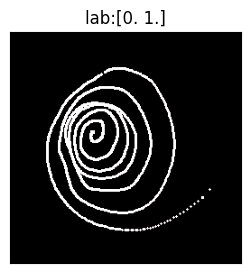

In [11]:
# task_list = ["alphabet", "freewriting", "house", "line1", "name", "rey", "spiral"]


db_path = os.path.join(pp,f"Dataset/hw_drawings", task)

X, y = load_images_vgg16(db_path)
X_train, y_train_c, X_val, y_val_c, X_test, y_test_c = split_data(X, y)


## Define model

### VGG16 model

In [2]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', name="dense")(x)
predictions = Dense(2, activation='softmax', name="prediction")(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

for i, layer in enumerate(model.layers):
   print(i, layer.name)


# img_path = 'elephant.jpg'
# img = keras.utils.load_img(img_path, target_size=(224, 224))
# x = keras.utils.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# features = model.predict(x)

model.summary()

0 input_layer
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d
20 dense
21 prediction


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Pretrained inception model

In [13]:


# # create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer -- let's say we have 200 classes
# predictions = Dense(2, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# model.summary()


# # compile the model (should be done *after* setting layers to non-trainable)
# # model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# # train the model on the new data for a few epochs


# # at this point, the top layers are well trained and we can start fine-tuning
# # convolutional layers from inception V3. We will freeze the bottom N layers
# # and train the remaining top layers.

# # # let's visualize layer names and layer indices to see how many layers
# # # we should freeze:
# # for i, layer in enumerate(base_model.layers):
# #    print(i, layer.name)

# # # we chose to train the top 2 inception blocks, i.e. we will freeze
# # # the first 249 layers and unfreeze the rest:
# # for layer in model.layers[:249]:
# #    layer.trainable = False
# # for layer in model.layers[249:]:
# #    layer.trainable = True

# # # we need to recompile the model for these modifications to take effect
# # # we use SGD with a low learning rate
# # from keras.optimizers import SGD
# # model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers


### CNN with regularization

In [14]:
# model = models.Sequential()

# # 1st Convolutional Layer
# model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 1)))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(dp))

# # 2nd Convolutional Layer
# model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(dp))

# # 3rd Convolutional Layer
# model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(dp))

# # Flatten and Fully Connected Layer
# model.add(layers.Flatten())
# model.add(layers.Dense(units=512, activation='relu'))
# model.add(layers.Dropout(dp))
# model.add(layers.Dense(units=2, activation='softmax'))  

# model.summary()

### CNN without normalization

In [15]:
# model_name = "CNN_3"

# model = models.Sequential()

# model.add(layers.Conv2D(filters=8, kernel_size=(5,5), padding='valid', activation='relu', input_shape=X_train[0].shape))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(layers.MaxPool2D(strides=2))

# #### Capas fully conected ####
# #### Clasification ####
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(2, activation='softmax'))

# model.summary()

## Train model

In [13]:


print("Model Training: ", model_name, "\n\n")

model_path = os.path.join(pp,"Models",task,model_name)
create_dir(model_path)

## Define model file ##
model_file = os.path.join(model_path, f"{model_name}_model.keras")
## Define log file
log_dir = os.path.join(model_path, f"fit/{model_name}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr, weight_decay=wd), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=md, patience=pt, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', verbose=1, mode='min')



tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train,
                    y_train_c,
                    epochs=epch,
                    batch_size=bz,
                    verbose=1,
                    validation_data=(X_val, y_val_c),
                    callbacks=[early_stopping, mcp_save, tensorboard_callback])



Model Training:  VGG16_test 


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.3358 - loss: 1.1812
Epoch 1: val_loss improved from inf to 1.26757, saving model to ../Models/spiral/VGG16_test/VGG16_test_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.3359 - loss: 1.1996 - val_accuracy: 0.3810 - val_loss: 1.2676
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4163 - loss: 1.3590
Epoch 2: val_loss improved from 1.26757 to 1.26680, saving model to ../Models/spiral/VGG16_test/VGG16_test_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.4110 - loss: 1.3655 - val_accuracy: 0.3810 - val_loss: 1.2668
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.3652 - loss: 1.3463
Epoch 3: val_loss improved from 1.26680 to 1.26605, saving model to ../Models/spiral/VGG16_test/VGG16_test_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.3633 - loss: 1.3536 - val_accuracy: 0.3810 - val_loss: 1.2661
Epoch 4

## Tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir "../Models/alphabet/CNN_3_Norm_Drop/CNN_3_Norm_Drop_model/fit"

## History

In [14]:

history_file = os.path.join(model_path, f"history_{model_name}.picl")
with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
file_pi.close()

In [15]:
with open(history_file, 'rb') as file_pi:
  history = pickle.load(file_pi)
file_pi.close()

pd.DataFrame.from_dict(history)

,accuracy,loss,val_accuracy,val_loss
0,0.337349,1.457472,0.380952,1.267573
1,0.337349,1.456590,0.380952,1.266799
2,0.337349,1.455601,0.380952,1.266052
3,0.337349,1.454661,0.380952,1.265323
4,0.349398,1.453603,0.380952,1.264670
5,0.349398,1.452673,0.380952,1.263953
6,0.349398,1.451654,0.380952,1.263289
7,0.349398,1.450797,0.380952,1.262498
8,0.349398,1.449686,0.333333,1.261830
9,0.349398,1.448745,0.333333,1.261116


## Training curves

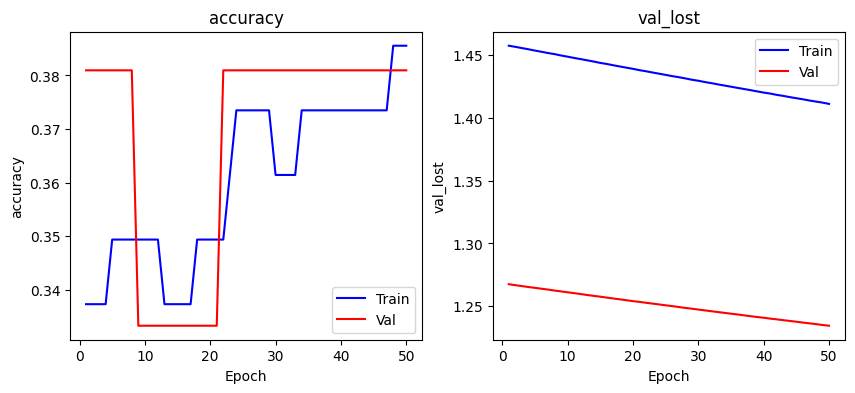

In [16]:

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1,len(acc)+1)


#### crear subplot ####
fig, ax = plt.subplots(1, 2, figsize=(10,4))
#### graficar curva acc ###
plotgraph(epochs, acc, val_acc, ax, 0, "accuracy")
#### graficar curva lost ###
plotgraph(epochs, loss, val_loss, ax, 1, "val_lost")

fig_file = os.path.join(model_path, f"history_{model_name}.pdf")
plt.savefig(fig_file)
plt.show()


## Test Model

In [18]:

model_file = os.path.join(model_path, f"{model_name}_model.keras")
print(model_file)

model = models.load_model(model_file)
model.summary()


../Models/spiral/VGG16_test/VGG16_test_model.keras


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,456 (56.89 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,846 (515.03 KB)

In [19]:
model.evaluate(X_train, y_train_c)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step - accuracy: 0.4037 - loss: 1.3800


[1.4106017351150513, 0.3855421543121338]

In [20]:
model.evaluate(X_val, y_val_c)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - accuracy: 0.3810 - loss: 1.2345


[1.2344987392425537, 0.380952388048172]

In [21]:
model.evaluate(X_test, y_test_c)
y_pred_c = model.predict(X_test)
y_pred = y_pred_c.argmax(axis=1)
y_true = y_test_c.argmax(axis=1)
print(y_true.shape, y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - accuracy: 0.1923 - loss: 1.5109
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
(26,) (26,)


## Report

In [22]:
#### Mostrar la microclasificación ####
label_dictionary = {
    0: "HC",
    1: "PD"

}
report = classification_report(y_true, y_pred, digits=4, output_dict=False, target_names=list(label_dictionary.values()))
table_report = classification_report(y_true, y_pred, digits=4, output_dict=True, target_names=list(label_dictionary.values()))
table_report = pd.DataFrame.from_dict(table_report).T
print(report)


              precision    recall  f1-score   support

          HC     0.2500    0.2000    0.2222        15
          PD     0.1429    0.1818    0.1600        11

    accuracy                         0.1923        26
   macro avg     0.1964    0.1909    0.1911        26
weighted avg     0.2047    0.1923    0.1959        26



## Confusion Matrix

0 0 0.9119607843137255
0 1 0.5384313725490196
1 0 0.5258208381391772
1 1 0.9193425605536332


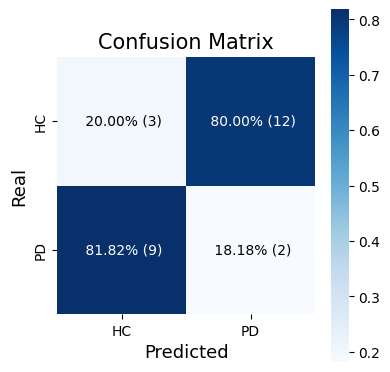

array([[0.2       , 0.8       ],
       [0.81818182, 0.18181818]])

In [23]:
labels = list(label_dictionary.values())
cm_file_save = os.path.join(model_path, f"CM_{model_name}.pdf")
confusion_matrix_plot(y_true, y_pred, cm_file_save,labels=labels, size=4, fz=15)


In [ ]:
df = pd.DataFrame([])
df["y_true"] = y_true
df["y_pred"] = y_pred
df


,y_true,y_pred
0,0,0
1,0,1
2,1,1
3,0,0
4,1,1
5,0,1
6,1,1
7,0,1
8,1,1
9,0,0
